In [1]:
from math import log, sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import sklearn.metrics as metrics
import psutil
import multiprocessing as mp

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
colors = np.array(['#0101DF','#DF0101','#01DF01'])

time0 = time.time()
rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('\nROC CURVE: %2.2f'%roc_auc_score(y_te2,y_p))

def plotting_ROC_curve(X_te,y_te,model):
    plt.figure()
    metrics.plot_roc_curve(model,X_te,y_te)
    plt.plot([0,1],[0,1],label='baseline',c='red')
    plt.legend(loc='lower right')
    plt.show()

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def adaboost(X_tr, y_tr, X_te, y_te):
    model = AdaBoostClassifier(random_state=rs)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'ADABOOST')
    plotting_ROC_curve(X_te,y_te,model=model)


def RandomForest (X_tr,y_tr,X_te,y_te):
    for i in range(2,4):
        print('dep: '+str(i))
        #RF por defecto utiliza 100 árboles de decisión. Este parámetro se cambia con n_estimators
        rfc = RandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1)
        rfc.fit(X_tr,y_tr)
        plotting_ROC_curve(X_te,y_te,model=rfc)
        y_pred = rfc.predict(X_te)
        print(rfc.feature_importances_)
        compute_metrics(y_te,y_pred,'RANDOM FOREST')

def CB(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = CatBoostClassifier(random_state=rs,verbose=1,learning_rate=Cvar[i],max_depth=2)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'CatBoost (learning_rate=%1.2f)'%Cvar[i])
            #plotting_ROC_curve(X_te,y_te,model=model)
        
def xgboost(X_tr, y_tr, X_te, y_te):
    model = XGBClassifier(random_state=rs,n_jobs=-1)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'XGBoost')
    plotting_ROC_curve(X_te,y_te,model=model)
    
def DT(X_tr, y_tr, X_te, y_te):
    for i in range(1,3):
        model = DecisionTreeClassifier(random_state=rs,max_depth=i)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'DECISION TREE')
        plotting_ROC_curve(X_te,y_te,model=model)
    
def KNN(X_tr, y_tr, X_te, y_te):
    nei = [3,25,50]
    for i in range(0,len(nei)):
        model = KNeighborsClassifier(n_neighbors=nei[i],weights='distance',n_jobs=-1)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'K-Neighbours (n_neighbors:%i)'%nei[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def SVCL(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = SVC(C=Cvar[i],kernel='sigmoid',degree=3,max_iter=100,random_state=rs,verbose=True)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'SVCL (C=%1.2f)'%Cvar[i])
            plotting_ROC_curve(X_te,y_te,model=model)
    
def BalancedRF(X_tr,y_tr,X_te,y_te):
    for i in range(1,3):
        print('dep: '+str(i))
        brfc = BalancedRandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1)
        brfc.fit(X_tr,y_tr)
        y_pred = brfc.predict(X_te)
        print(brfc.feature_importances_)
        compute_metrics(y_te,y_pred,'BALANCED RANDOM FOREST')
        plotting_ROC_curve(X_te,y_te,model=brfc)

def EasyEnsamble(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = EasyEnsembleClassifier(n_estimators=nest[i],warm_start=True,n_jobs=-1,random_state=rs, verbose=1,replacement=True)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'Easy Ensemble Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def RUSBoost(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = RUSBoostClassifier(n_estimators=nest[i],learning_rate=0.01,replacement=True,random_state=rs)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'RUS Boost Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)

def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()

Using TensorFlow backend.


Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426905, 1: 113031})
0: 92.66%
1: 7.34%


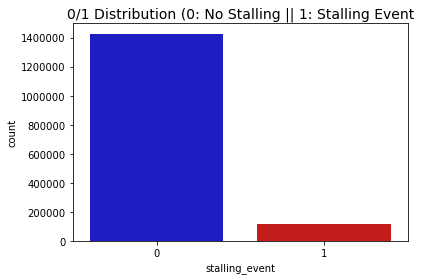

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['tcp_flag_cwr']
del dataset['tcp_flag_ecn']
del dataset['tcp_flag_urg']
del dataset['ip_len']
del dataset['tcp_flag_psh']
del dataset['tcp_flag_fin']
del dataset['prebuffering']
del dataset['Time']

dataset = dataset.fillna(dataset.mean())

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

(1539936, 10)
(1538832, 10)
0.4992

dataset[stalling_event]
Counter({0: 1425825, 1: 113007})
0: 92.66%
1: 7.34%
Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')
       ∆t  pkt_len  tcp_hea_len  tcp_flag_ack  tcp_flag_rst  tcp_flag_syn  \
0  0.0000       66         32.0           0.0           0.0           1.0   
1  0.0327       66         32.0           1.0           0.0           1.0   
2  0.0002       54         20.0           1.0           0.0           0.0   
3  0.0017      396         20.0           1.0           0.0           0.0   
4  0.0363      551         20.0           1.0           0.0           0.0   

   tcp_win_si2  
0       8192.0  
1      65000.0  
2        256.0  
3        256.0  
4      64658.0  
0    0
1    0
2    0
3    0
4    0
Name: stalling_event, dtype: int64


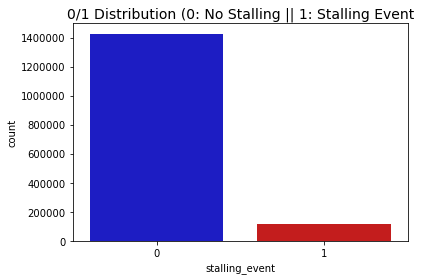

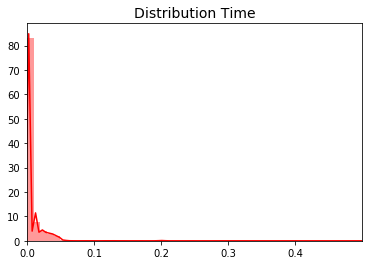

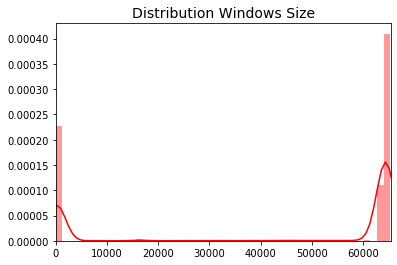

<Figure size 432x288 with 0 Axes>

In [3]:
id = list(dataset[dataset['∆t']>0.5].index)
print(dataset.shape)
dataset = dataset.drop(id)
print(dataset.shape)
print(max(dataset['∆t']))
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

time_val = dataset['∆t'].values
win_val = dataset['tcp_win_si2'].values

fig = plt.figure()
sns.distplot(time_val,color='r')
plt.title('Distribution Time',fontsize=14)
plt.xlim([min(time_val),max(time_val)])

fig = plt.figure()
sns.distplot(win_val,color='r')
plt.title('Distribution Windows Size',fontsize=14)
plt.xlim([min(win_val),max(win_val)])
fig = plt.figure()

print(dataset.columns)
y = dataset['stalling_event']
X = dataset.drop(['delay','capture','stalling_event'],axis=1)
print(X.head())
print(y.head())

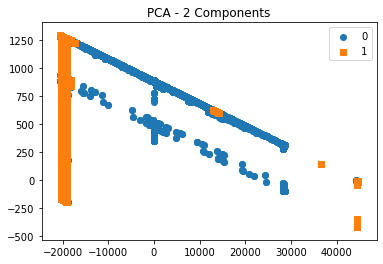

In [4]:
pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(X)
plot_2d_space(X_train_pca, y,'PCA - 2 Components')

In [5]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X.values,y.values)
Ratio10(y_rus,'y_rus')
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_rus)

Ratio10(y_train_rus,'y_train_rus')
Ratio10(y_test_rus,'y_test_rus')


y_rus
Counter({0: 113007, 1: 113007})
0: 50.00%
1: 50.00%

y_train_rus
Counter({1: 90406, 0: 90405})
0: 50.00%
1: 50.00%

y_test_rus
Counter({0: 22602, 1: 22601})
0: 50.00%
1: 50.00%


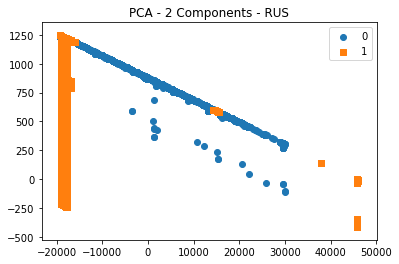

In [6]:
pca = PCA(n_components=2)
X_rus_pca=pca.fit_transform(X_rus)
plot_2d_space(X_rus_pca, y_rus.T.ravel(),'PCA - 2 Components - RUS')

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X.values,y.values)
Ratio10(y_ros,'y_ros')
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_ros)

Ratio10(y_train_ros,'y_train_ros')
Ratio10(y_test_ros,'y_test_ros')


y_ros
Counter({0: 1425825, 1: 1425825})
0: 50.00%
1: 50.00%

y_train_ros
Counter({1: 1140660, 0: 1140660})
0: 50.00%
1: 50.00%

y_test_ros
Counter({1: 285165, 0: 285165})
0: 50.00%
1: 50.00%


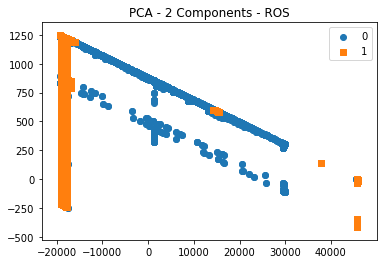

In [8]:
pca = PCA(n_components=2)
X_ros_pca=pca.fit_transform(X_ros)
plot_2d_space(X_ros_pca, y_ros.T.ravel(),'PCA - 2 Components - ROS')

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X_sm, y_sm = smote.fit_sample(X.values, y.values)
Ratio10(y_sm,'y_sm')
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_sm)

Ratio10(y_train_sm,'y_train_sm')
Ratio10(y_test_sm,'y_test_sm')


y_sm
Counter({0: 1425825, 1: 1425825})
0: 50.00%
1: 50.00%

y_train_sm
Counter({1: 1140660, 0: 1140660})
0: 50.00%
1: 50.00%

y_test_sm
Counter({1: 285165, 0: 285165})
0: 50.00%
1: 50.00%


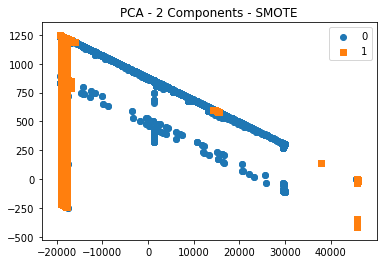

In [10]:
pca = PCA(n_components=2)
X_sm_pca=pca.fit_transform(X_sm)
plot_2d_space(X_sm_pca, y_sm.T.ravel(),'PCA - 2 Components - SMOTE')

In [11]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X_ad, y_ad = adasyn.fit_sample(X.values, y.values)
Ratio10(y_ad,'y_ad')
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_ad, y_ad,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=y_ad)

Ratio10(y_train_ad,'y_train_ad')
Ratio10(y_test_ad,'y_test_ad')


y_ad
Counter({1: 1439653, 0: 1425825})
0: 49.76%
1: 50.24%

y_train_ad
Counter({1: 1151722, 0: 1140660})
0: 49.76%
1: 50.24%

y_test_ad
Counter({1: 287931, 0: 285165})
0: 49.76%
1: 50.24%


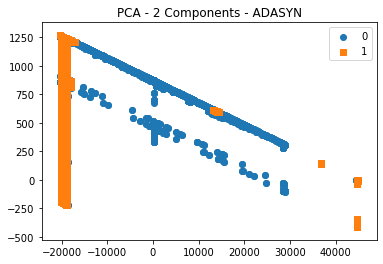

In [12]:
pca = PCA(n_components=2)
X_ad_pca=pca.fit_transform(X_ad)
plot_2d_space(X_ad_pca, y_ad.T.ravel(),'PCA - 2 Components - ADASYN')

dep: 2
[0.18590334 0.04069567 0.05303018 0.14777311 0.17672824 0.03615285
 0.35971661]

 RANDOM FOREST
CONFUSION MATRIX
[[14414  8188]
 [11857 10744]]
              precision    recall  f1-score   support

           0       0.55      0.64      0.59     22602
           1       0.57      0.48      0.52     22601

    accuracy                           0.56     45203
   macro avg       0.56      0.56      0.55     45203
weighted avg       0.56      0.56      0.55     45203


ROC CURVE: 0.56
dep: 3
[0.15616007 0.06078015 0.05560563 0.12051043 0.11898548 0.03488789
 0.45307035]

 RANDOM FOREST
CONFUSION MATRIX
[[15926  6676]
 [12518 10083]]
              precision    recall  f1-score   support

           0       0.56      0.70      0.62     22602
           1       0.60      0.45      0.51     22601

    accuracy                           0.58     45203
   macro avg       0.58      0.58      0.57     45203
weighted avg       0.58      0.58      0.57     45203


ROC CURVE: 0.58


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

<Figure size 432x288 with 0 Axes>

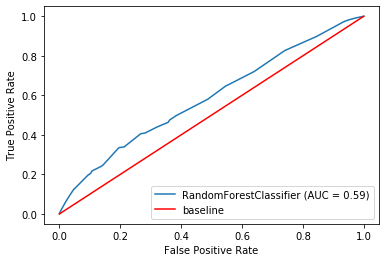

<Figure size 432x288 with 0 Axes>

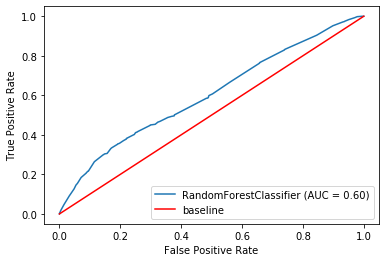

In [13]:
#RANDOM UNDER SAMPLING
RandomForest(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[0.06 0.   0.02 0.   0.02 0.02 0.88]

 ADABOOST
CONFUSION MATRIX
[[16802  5800]
 [11604 10997]]
              precision    recall  f1-score   support

           0       0.59      0.74      0.66     22602
           1       0.65      0.49      0.56     22601

    accuracy                           0.61     45203
   macro avg       0.62      0.61      0.61     45203
weighted avg       0.62      0.61      0.61     45203


ROC CURVE: 0.61


<Figure size 432x288 with 0 Axes>

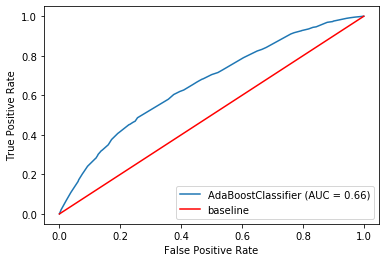

In [14]:
adaboost(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[0.06715356 0.11629306 0.03059218 0.15091656 0.18505765 0.07035778
 0.37962922]

 XGBoost
CONFUSION MATRIX
[[16353  6249]
 [ 9895 12706]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     22602
           1       0.67      0.56      0.61     22601

    accuracy                           0.64     45203
   macro avg       0.65      0.64      0.64     45203
weighted avg       0.65      0.64      0.64     45203


ROC CURVE: 0.64


<Figure size 432x288 with 0 Axes>

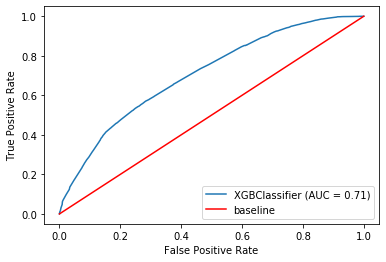

In [15]:
xgboost(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[14610  7992]
 [12411 10190]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59     22602
           1       0.56      0.45      0.50     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.54     45203
weighted avg       0.55      0.55      0.54     45203


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[17178  5424]
 [14316  8285]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     22602
           1       0.60      0.37      0.46     22601

    accuracy                           0.56     45203
   macro avg       0.57      0.56      0.55     45203
weighted avg       0.57      0.56      0.55     45203


ROC CURVE: 0.56


<Figure size 432x288 with 0 Axes>

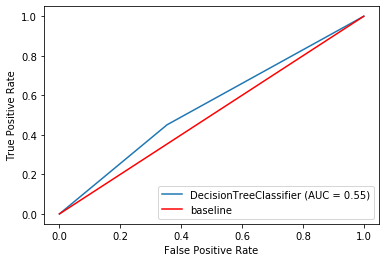

<Figure size 432x288 with 0 Axes>

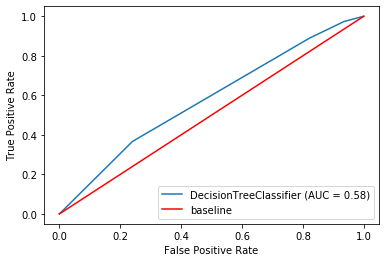

In [16]:
DT(X_train_rus,y_train_rus,X_test_rus,y_test_rus)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[16071  6531]
 [11116 11485]]
              precision    recall  f1-score   support

           0       0.59      0.71      0.65     22602
           1       0.64      0.51      0.57     22601

    accuracy                           0.61     45203
   macro avg       0.61      0.61      0.61     45203
weighted avg       0.61      0.61      0.61     45203


ROC CURVE: 0.61

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[16337  6265]
 [10000 12601]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     22602
           1       0.67      0.56      0.61     22601

    accuracy                           0.64     45203
   macro avg       0.64      0.64      0.64     45203
weighted avg       0.64      0.64      0.64     45203


ROC CURVE: 0.64

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[16262  6340]
 [ 9756 12845]]
              precision    recall  f1-score   support

           0      

<Figure size 432x288 with 0 Axes>

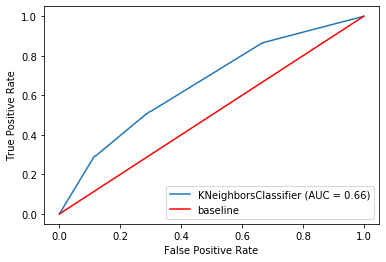

<Figure size 432x288 with 0 Axes>

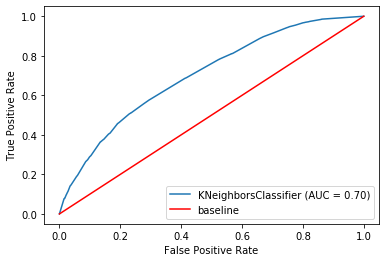

<Figure size 432x288 with 0 Axes>

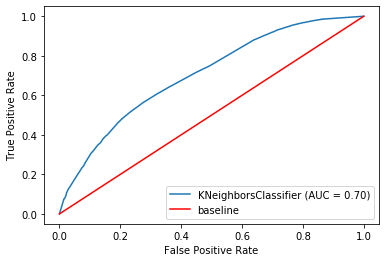

In [17]:
KNN(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[ 6840 15762]
 [ 5903 16698]]
              precision    recall  f1-score   support

           0       0.54      0.30      0.39     22602
           1       0.51      0.74      0.61     22601

    accuracy                           0.52     45203
   macro avg       0.53      0.52      0.50     45203
weighted avg       0.53      0.52      0.50     45203


ROC CURVE: 0.52
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[ 6840 15762]
 [ 5903 16698]]
              precision    recall  f1-score   support

           0       0.54      0.30      0.39     22602
           1       0.51      0.74      0.61     22601

    accuracy                           0.52     45203
   macro avg       0.53      0.52      0.50     45203
weighted avg       0.53      0.52      0.50     45203


ROC CURVE: 0.52
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[ 6840 15762]
 [ 5903 16698]]
              precision    recall  f1-score   support

           0       0.54      0.30      0.

<Figure size 432x288 with 0 Axes>

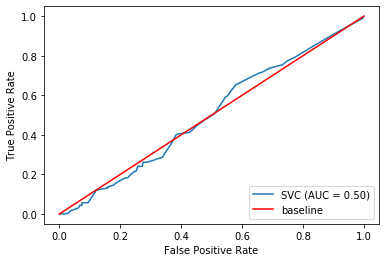

<Figure size 432x288 with 0 Axes>

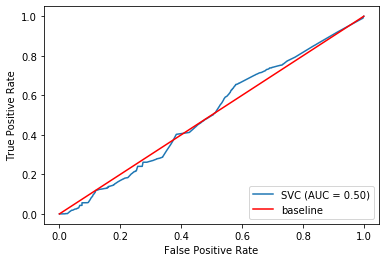

<Figure size 432x288 with 0 Axes>

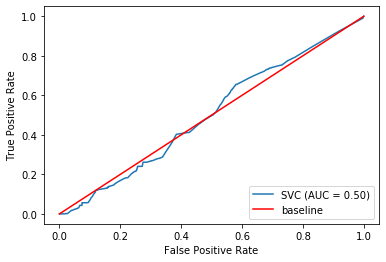

<Figure size 432x288 with 0 Axes>

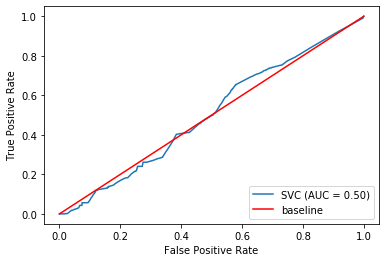

In [18]:
SVCL(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

dep: 1
[0.12 0.   0.06 0.25 0.2  0.08 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[14546  8056]
 [12160 10441]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59     22602
           1       0.56      0.46      0.51     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.55     45203
weighted avg       0.55      0.55      0.55     45203


ROC CURVE: 0.55
dep: 2
[0.14857052 0.0459898  0.05240021 0.17830083 0.14688343 0.03315691
 0.3946983 ]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[14535  8067]
 [12140 10461]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59     22602
           1       0.56      0.46      0.51     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.55     45203
weighted avg       0.55      0.55      0.55     45203


ROC CURVE: 0.55


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

<Figure size 432x288 with 0 Axes>

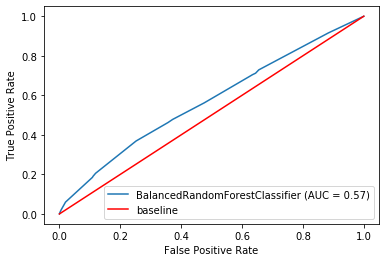

<Figure size 432x288 with 0 Axes>

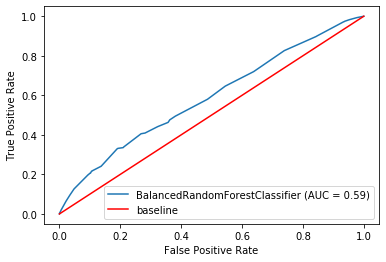

In [19]:
BalancedRF(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.9s remaining:   16.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[16907  5695]
 [11669 10932]]
              precision    recall  f1-score   support

           0       0.59      0.75      0.66     22602
           1       0.66      0.48      0.56     22601

    accuracy                           0.62     45203
   macro avg       0.62      0.62      0.61     45203
weighted avg       0.62      0.62      0.61     45203


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[16905  5697]
 [11661 10940]]
              precision    recall  f1-score   support

           0       0.59      0.75      0.66     22602
           1       0.66      0.48      0.56     22601

    accuracy                           0.62     45203
   macro avg       0.62      0.62      0.61     45203
weighted avg       0.62      0.62      0.61     45203


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[16921  5681]
 [11671 10930]]
              precision    rec

<Figure size 432x288 with 0 Axes>

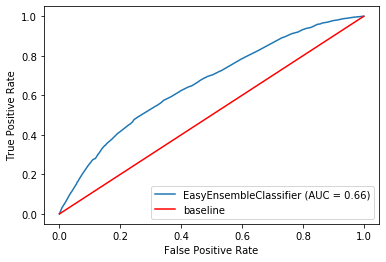

<Figure size 432x288 with 0 Axes>

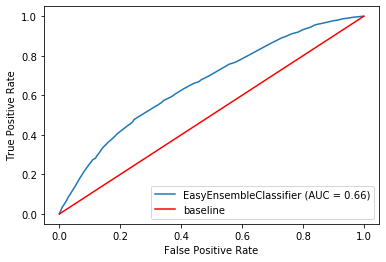

<Figure size 432x288 with 0 Axes>

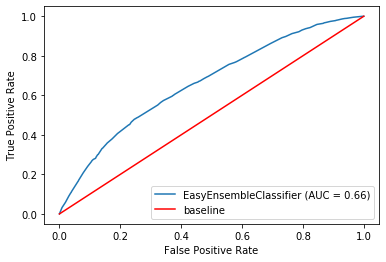

In [20]:
EasyEnsamble(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[14610  7992]
 [12411 10190]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59     22602
           1       0.56      0.45      0.50     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.54     45203
weighted avg       0.55      0.55      0.54     45203


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[14610  7992]
 [12411 10190]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59     22602
           1       0.56      0.45      0.50     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.54     45203
weighted avg       0.55      0.55      0.54     45203


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MATRIX
[[14

<Figure size 432x288 with 0 Axes>

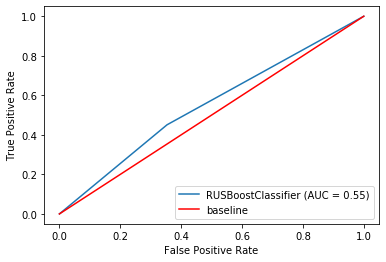

<Figure size 432x288 with 0 Axes>

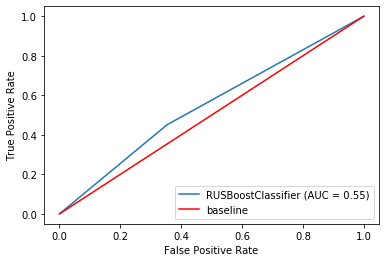

<Figure size 432x288 with 0 Axes>

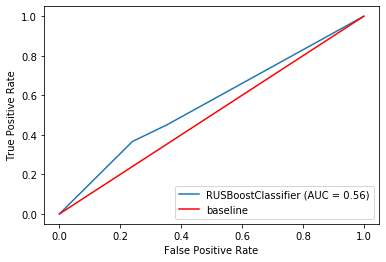

In [21]:
RUSBoost(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

In [22]:
CB(X_train_rus,y_train_rus,X_test_rus,y_test_rus)

0:	learn: 0.6929462	total: 77.6ms	remaining: 1m 17s
1:	learn: 0.6927508	total: 95ms	remaining: 47.4s
2:	learn: 0.6925616	total: 114ms	remaining: 37.8s
3:	learn: 0.6923764	total: 130ms	remaining: 32.4s
4:	learn: 0.6921879	total: 151ms	remaining: 30.1s
5:	learn: 0.6920144	total: 168ms	remaining: 27.9s
6:	learn: 0.6918414	total: 190ms	remaining: 27s
7:	learn: 0.6916733	total: 208ms	remaining: 25.7s
8:	learn: 0.6915040	total: 225ms	remaining: 24.8s
9:	learn: 0.6913424	total: 242ms	remaining: 24s
10:	learn: 0.6911711	total: 266ms	remaining: 23.9s
11:	learn: 0.6910089	total: 285ms	remaining: 23.5s
12:	learn: 0.6908478	total: 307ms	remaining: 23.3s
13:	learn: 0.6906960	total: 325ms	remaining: 22.9s
14:	learn: 0.6905458	total: 344ms	remaining: 22.6s
15:	learn: 0.6903945	total: 371ms	remaining: 22.8s
16:	learn: 0.6902457	total: 388ms	remaining: 22.5s
17:	learn: 0.6901055	total: 412ms	remaining: 22.5s
18:	learn: 0.6899518	total: 429ms	remaining: 22.2s
19:	learn: 0.6898012	total: 462ms	remaining:

dep: 2
[0.16848332 0.03966564 0.04151855 0.14752389 0.18958593 0.05009469
 0.36312799]

 RANDOM FOREST
CONFUSION MATRIX
[[182820 102345]
 [153277 131888]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330


ROC CURVE: 0.55
dep: 3
[0.13457904 0.06382649 0.05119118 0.11492395 0.13300229 0.03858012
 0.46389693]

 RANDOM FOREST
CONFUSION MATRIX
[[207145  78020]
 [165371 119794]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.63    285165
           1       0.61      0.42      0.50    285165

    accuracy                           0.57    570330
   macro avg       0.58      0.57      0.56    570330
weighted avg       0.58      0.57      0.56    570330


ROC CURVE: 0.57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel

<Figure size 432x288 with 0 Axes>

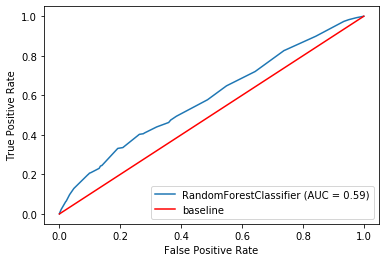

<Figure size 432x288 with 0 Axes>

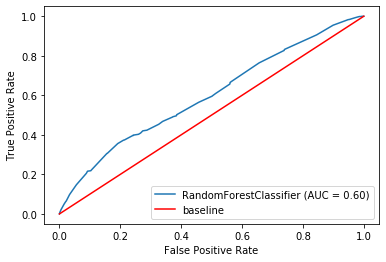

In [23]:
#RANDOM OVER SAMPLING
RandomForest(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[0.14 0.   0.02 0.   0.02 0.02 0.8 ]

 ADABOOST
CONFUSION MATRIX
[[185047 100118]
 [122270 162895]]
              precision    recall  f1-score   support

           0       0.60      0.65      0.62    285165
           1       0.62      0.57      0.59    285165

    accuracy                           0.61    570330
   macro avg       0.61      0.61      0.61    570330
weighted avg       0.61      0.61      0.61    570330


ROC CURVE: 0.61


<Figure size 432x288 with 0 Axes>

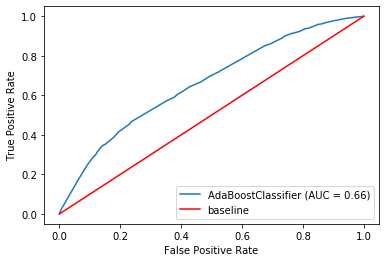

In [24]:
adaboost(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[0.05675938 0.14333354 0.03885384 0.12399338 0.16078557 0.05337804
 0.42289618]

 XGBoost
CONFUSION MATRIX
[[211005  74160]
 [130133 155032]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.67    285165
           1       0.68      0.54      0.60    285165

    accuracy                           0.64    570330
   macro avg       0.65      0.64      0.64    570330
weighted avg       0.65      0.64      0.64    570330


ROC CURVE: 0.64


<Figure size 432x288 with 0 Axes>

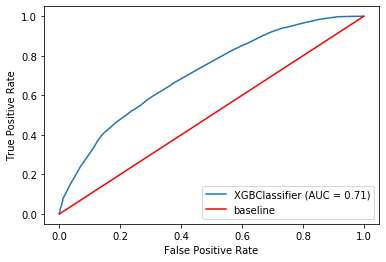

In [25]:
xgboost(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156827 128338]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[217311  67854]
 [180795 104370]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64    285165
           1       0.61      0.37      0.46    285165

    accuracy                           0.56    570330
   macro avg       0.58      0.56      0.55    570330
weighted avg       0.58      0.56      0.55    570330


ROC CURVE: 0.56


<Figure size 432x288 with 0 Axes>

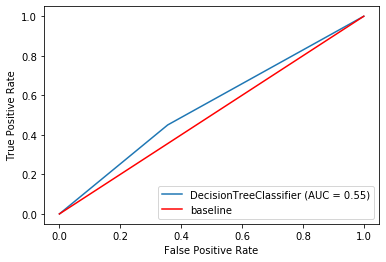

<Figure size 432x288 with 0 Axes>

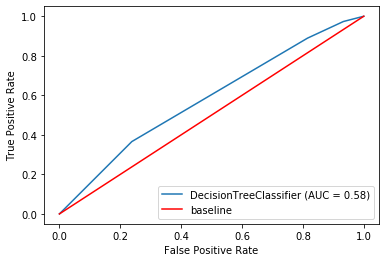

In [26]:
DT(X_train_ros,y_train_ros,X_test_ros,y_test_ros)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[167826 117339]
 [ 94739 190426]]
              precision    recall  f1-score   support

           0       0.64      0.59      0.61    285165
           1       0.62      0.67      0.64    285165

    accuracy                           0.63    570330
   macro avg       0.63      0.63      0.63    570330
weighted avg       0.63      0.63      0.63    570330


ROC CURVE: 0.63

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[172163 113002]
 [ 83389 201776]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.64    285165
           1       0.64      0.71      0.67    285165

    accuracy                           0.66    570330
   macro avg       0.66      0.66      0.65    570330
weighted avg       0.66      0.66      0.65    570330


ROC CURVE: 0.66

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[170004 115161]
 [ 76471 208694]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

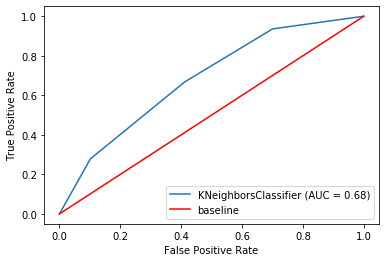

<Figure size 432x288 with 0 Axes>

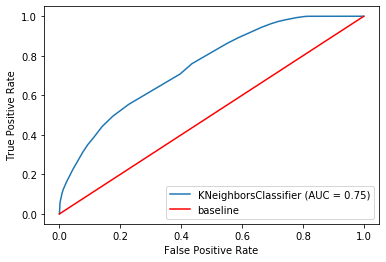

<Figure size 432x288 with 0 Axes>

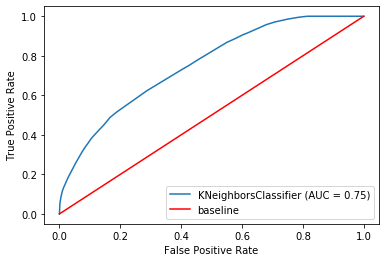

In [27]:
KNN(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[199077  86088]
 [210221  74944]]
              precision    recall  f1-score   support

           0       0.49      0.70      0.57    285165
           1       0.47      0.26      0.34    285165

    accuracy                           0.48    570330
   macro avg       0.48      0.48      0.45    570330
weighted avg       0.48      0.48      0.45    570330


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[199077  86088]
 [210221  74944]]
              precision    recall  f1-score   support

           0       0.49      0.70      0.57    285165
           1       0.47      0.26      0.34    285165

    accuracy                           0.48    570330
   macro avg       0.48      0.48      0.45    570330
weighted avg       0.48      0.48      0.45    570330


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[199077  86088]
 [210221  74944]]
              precision    recall  f1-score   support

           0       0.49      

<Figure size 432x288 with 0 Axes>

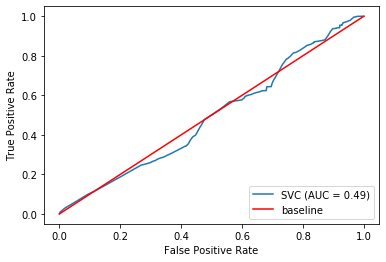

<Figure size 432x288 with 0 Axes>

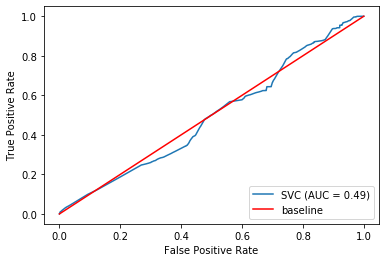

<Figure size 432x288 with 0 Axes>

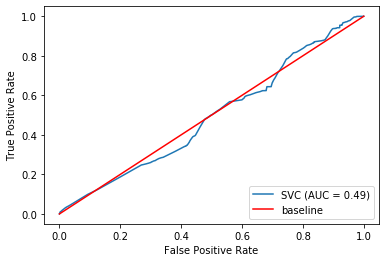

<Figure size 432x288 with 0 Axes>

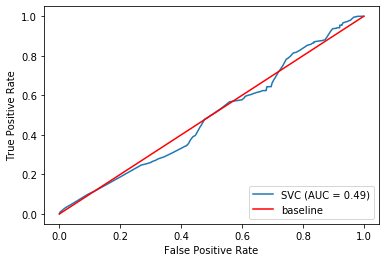

In [28]:
SVCL(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

dep: 1
[0.1  0.   0.06 0.23 0.24 0.08 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [153398 131767]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330


ROC CURVE: 0.55
dep: 2
[0.12989797 0.03989754 0.04534573 0.17575513 0.17687202 0.04165425
 0.39057737]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182882 102283]
 [153350 131815]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330


ROC CURVE: 0.55


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

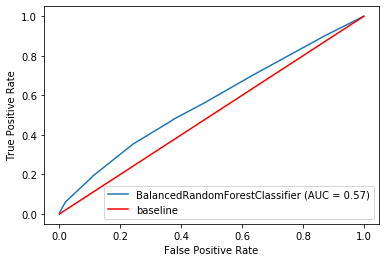

<Figure size 432x288 with 0 Axes>

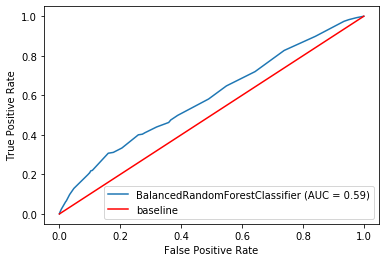

In [29]:
BalancedRF(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.4s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.6s remaining:   11.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  9.3min remaining:  9.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[217583  67582]
 [151695 133470]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.66    285165
           1       0.66      0.47      0.55    285165

    accuracy                           0.62    570330
   macro avg       0.63      0.62      0.61    570330
weighted avg       0.63      0.62      0.61    570330


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[217695  67470]
 [151931 133234]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.66    285165
           1       0.66      0.47      0.55    285165

    accuracy                           0.62    570330
   macro avg       0.63      0.62      0.61    570330
weighted avg       0.63      0.62      0.61    570330


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[217671  67494]
 [151931 133234]]
              prec

<Figure size 432x288 with 0 Axes>

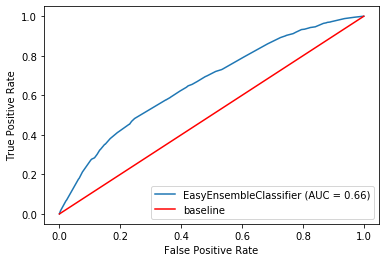

<Figure size 432x288 with 0 Axes>

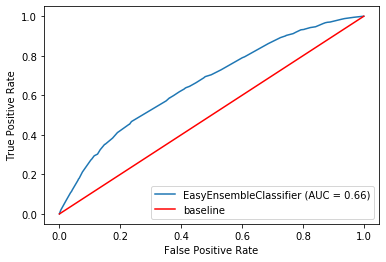

<Figure size 432x288 with 0 Axes>

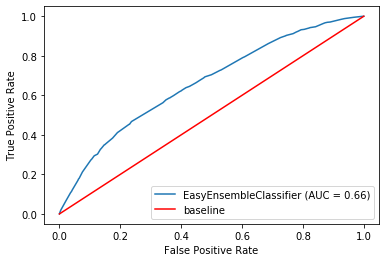

In [30]:
EasyEnsamble(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[183725 101440]
 [156827 128338]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[183725 101440]
 [156827 128338]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

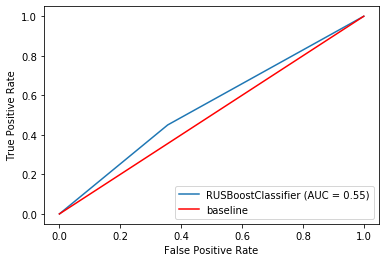

<Figure size 432x288 with 0 Axes>

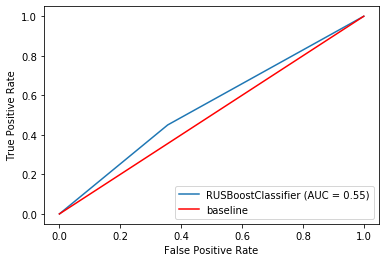

<Figure size 432x288 with 0 Axes>

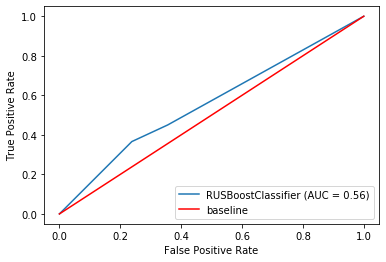

In [31]:
RUSBoost(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

In [32]:
CB(X_train_ros,y_train_ros,X_test_ros,y_test_ros)

0:	learn: 0.6929416	total: 284ms	remaining: 4m 43s
1:	learn: 0.6927347	total: 595ms	remaining: 4m 56s
2:	learn: 0.6925345	total: 932ms	remaining: 5m 9s
3:	learn: 0.6923443	total: 1.26s	remaining: 5m 14s
4:	learn: 0.6921525	total: 1.64s	remaining: 5m 25s
5:	learn: 0.6919670	total: 2s	remaining: 5m 32s
6:	learn: 0.6917860	total: 2.36s	remaining: 5m 34s
7:	learn: 0.6916040	total: 2.73s	remaining: 5m 38s
8:	learn: 0.6914256	total: 3.13s	remaining: 5m 44s
9:	learn: 0.6912427	total: 3.47s	remaining: 5m 43s
10:	learn: 0.6910706	total: 3.79s	remaining: 5m 41s
11:	learn: 0.6909030	total: 4.11s	remaining: 5m 38s
12:	learn: 0.6907340	total: 4.44s	remaining: 5m 37s
13:	learn: 0.6905730	total: 4.77s	remaining: 5m 36s
14:	learn: 0.6904093	total: 5.1s	remaining: 5m 35s
15:	learn: 0.6902493	total: 5.46s	remaining: 5m 35s
16:	learn: 0.6900860	total: 5.78s	remaining: 5m 34s
17:	learn: 0.6899305	total: 6.1s	remaining: 5m 32s
18:	learn: 0.6897805	total: 6.43s	remaining: 5m 31s
19:	learn: 0.6896220	total: 

dep: 2
[0.16074054 0.04019104 0.04063371 0.15282847 0.17686711 0.0558629
 0.37287623]

 RANDOM FOREST
CONFUSION MATRIX
[[182820 102345]
 [153128 132037]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330


ROC CURVE: 0.55
dep: 3
[0.14219168 0.06778353 0.05197134 0.12255182 0.12068377 0.04405904
 0.45075882]

 RANDOM FOREST
CONFUSION MATRIX
[[207052  78113]
 [165198 119967]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.63    285165
           1       0.61      0.42      0.50    285165

    accuracy                           0.57    570330
   macro avg       0.58      0.57      0.56    570330
weighted avg       0.58      0.57      0.56    570330


ROC CURVE: 0.57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

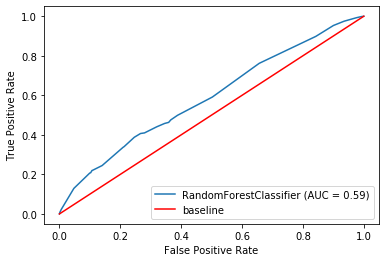

<Figure size 432x288 with 0 Axes>

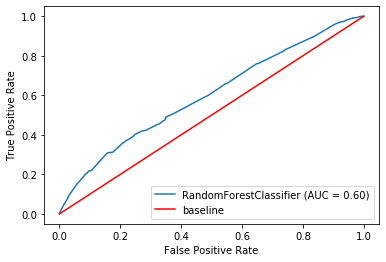

In [33]:
#SMOTE
RandomForest(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[0.04 0.02 0.02 0.   0.02 0.02 0.88]

 ADABOOST
CONFUSION MATRIX
[[217238  67927]
 [150719 134446]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.67    285165
           1       0.66      0.47      0.55    285165

    accuracy                           0.62    570330
   macro avg       0.63      0.62      0.61    570330
weighted avg       0.63      0.62      0.61    570330


ROC CURVE: 0.62


<Figure size 432x288 with 0 Axes>

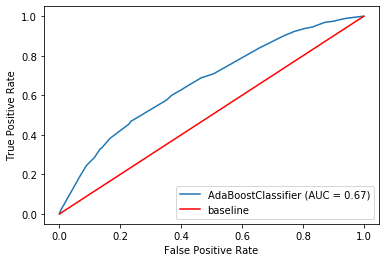

In [34]:
adaboost(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[0.03420146 0.32819965 0.03455398 0.11309073 0.14950873 0.05495997
 0.28548548]

 XGBoost
CONFUSION MATRIX
[[205038  80127]
 [127423 157742]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.66    285165
           1       0.66      0.55      0.60    285165

    accuracy                           0.64    570330
   macro avg       0.64      0.64      0.63    570330
weighted avg       0.64      0.64      0.63    570330


ROC CURVE: 0.64


<Figure size 432x288 with 0 Axes>

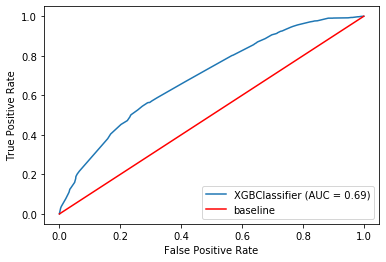

In [35]:
xgboost(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156687 128478]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[217311  67854]
 [180592 104573]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64    285165
           1       0.61      0.37      0.46    285165

    accuracy                           0.56    570330
   macro avg       0.58      0.56      0.55    570330
weighted avg       0.58      0.56      0.55    570330


ROC CURVE: 0.56


<Figure size 432x288 with 0 Axes>

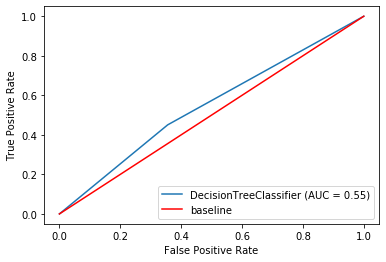

<Figure size 432x288 with 0 Axes>

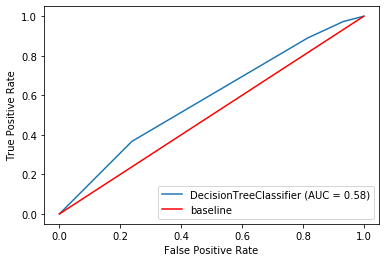

In [36]:
DT(X_train_sm,y_train_sm,X_test_sm,y_test_sm)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[192542  92623]
 [109105 176060]]
              precision    recall  f1-score   support

           0       0.64      0.68      0.66    285165
           1       0.66      0.62      0.64    285165

    accuracy                           0.65    570330
   macro avg       0.65      0.65      0.65    570330
weighted avg       0.65      0.65      0.65    570330


ROC CURVE: 0.65

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[215605  69560]
 [117408 167757]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.70    285165
           1       0.71      0.59      0.64    285165

    accuracy                           0.67    570330
   macro avg       0.68      0.67      0.67    570330
weighted avg       0.68      0.67      0.67    570330


ROC CURVE: 0.67

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[220090  65075]
 [119810 165355]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

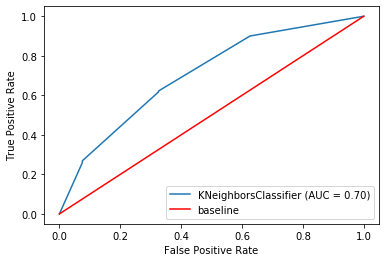

<Figure size 432x288 with 0 Axes>

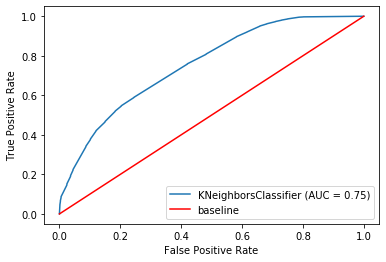

<Figure size 432x288 with 0 Axes>

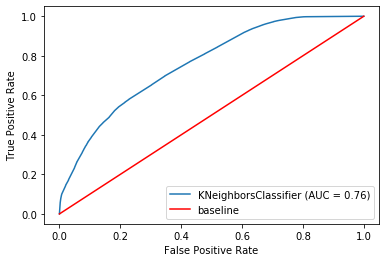

In [37]:
KNN(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[199077  86088]
 [209988  75177]]
              precision    recall  f1-score   support

           0       0.49      0.70      0.57    285165
           1       0.47      0.26      0.34    285165

    accuracy                           0.48    570330
   macro avg       0.48      0.48      0.46    570330
weighted avg       0.48      0.48      0.46    570330


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[199077  86088]
 [209988  75177]]
              precision    recall  f1-score   support

           0       0.49      0.70      0.57    285165
           1       0.47      0.26      0.34    285165

    accuracy                           0.48    570330
   macro avg       0.48      0.48      0.46    570330
weighted avg       0.48      0.48      0.46    570330


ROC CURVE: 0.48
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[199077  86088]
 [209988  75177]]
              precision    recall  f1-score   support

           0       0.49      

<Figure size 432x288 with 0 Axes>

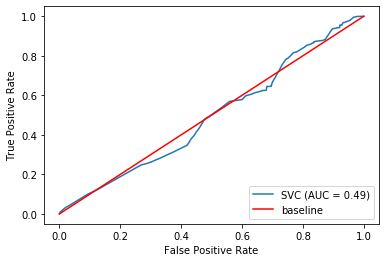

<Figure size 432x288 with 0 Axes>

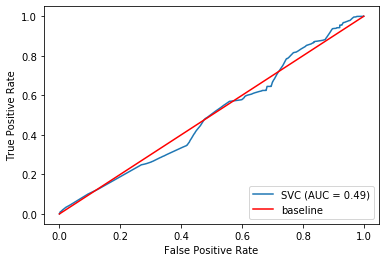

<Figure size 432x288 with 0 Axes>

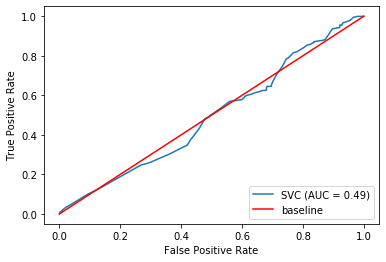

<Figure size 432x288 with 0 Axes>

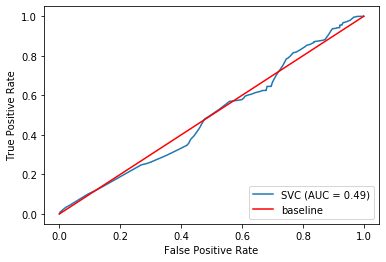

In [38]:
SVCL(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

dep: 1
[0.1  0.   0.06 0.23 0.24 0.08 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [153259 131906]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330


ROC CURVE: 0.55
dep: 2
[0.12898382 0.04163578 0.04586389 0.17541838 0.18807264 0.04434735
 0.37567813]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[192117  93048]
 [155963 129202]]
              precision    recall  f1-score   support

           0       0.55      0.67      0.61    285165
           1       0.58      0.45      0.51    285165

    accuracy                           0.56    570330
   macro avg       0.57      0.56      0.56    570330
weighted avg       0.57      0.56      0.56    570330


ROC CURVE: 0.56


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel

<Figure size 432x288 with 0 Axes>

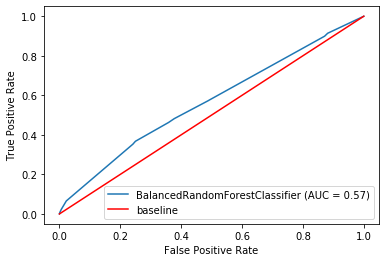

<Figure size 432x288 with 0 Axes>

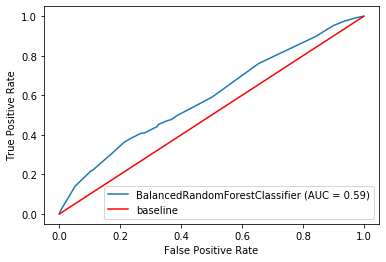

In [39]:
BalancedRF(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.3s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  9.3min remaining:  9.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[217080  68085]
 [150537 134628]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.67    285165
           1       0.66      0.47      0.55    285165

    accuracy                           0.62    570330
   macro avg       0.63      0.62      0.61    570330
weighted avg       0.63      0.62      0.61    570330


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[217225  67940]
 [150679 134486]]
              precision    recall  f1-score   support

           0       0.59      0.76      0.67    285165
           1       0.66      0.47      0.55    285165

    accuracy                           0.62    570330
   macro avg       0.63      0.62      0.61    570330
weighted avg       0.63      0.62      0.61    570330


ROC CURVE: 0.62

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[217214  67951]
 [150665 134500]]
              prec

<Figure size 432x288 with 0 Axes>

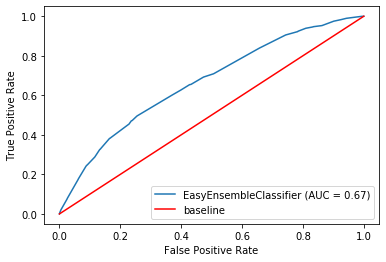

<Figure size 432x288 with 0 Axes>

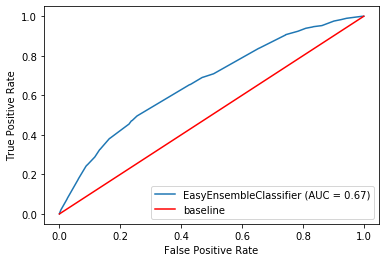

<Figure size 432x288 with 0 Axes>

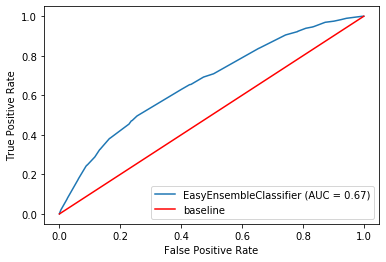

In [40]:
EasyEnsamble(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[183725 101440]
 [156687 128478]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[183725 101440]
 [156687 128478]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

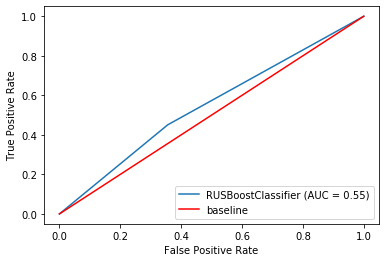

<Figure size 432x288 with 0 Axes>

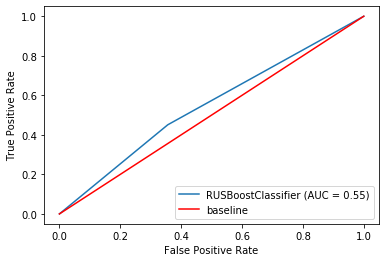

<Figure size 432x288 with 0 Axes>

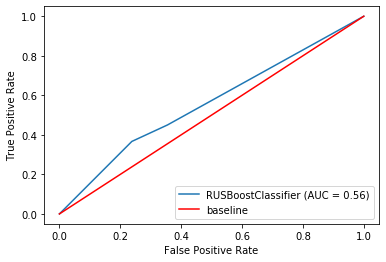

In [41]:
RUSBoost(X_train_sm,y_train_sm,X_test_sm,y_test_sm)

In [42]:
CB(X_train_sm,y_train_sm,X_test_sm,y_test_sm)


0:	learn: 0.6929419	total: 280ms	remaining: 4m 39s
1:	learn: 0.6927405	total: 576ms	remaining: 4m 47s
2:	learn: 0.6925423	total: 940ms	remaining: 5m 12s
3:	learn: 0.6923490	total: 1.93s	remaining: 7m 59s
4:	learn: 0.6921530	total: 2.34s	remaining: 7m 45s
5:	learn: 0.6919647	total: 2.81s	remaining: 7m 44s
6:	learn: 0.6917838	total: 3.37s	remaining: 7m 58s
7:	learn: 0.6916016	total: 4.01s	remaining: 8m 17s
8:	learn: 0.6914255	total: 4.79s	remaining: 8m 47s
9:	learn: 0.6912504	total: 5.49s	remaining: 9m 3s
10:	learn: 0.6910769	total: 5.88s	remaining: 8m 49s
11:	learn: 0.6909074	total: 6.27s	remaining: 8m 36s
12:	learn: 0.6907409	total: 6.64s	remaining: 8m 24s
13:	learn: 0.6905770	total: 7.05s	remaining: 8m 16s
14:	learn: 0.6904169	total: 7.62s	remaining: 8m 20s
15:	learn: 0.6902562	total: 7.96s	remaining: 8m 9s
16:	learn: 0.6900991	total: 8.32s	remaining: 8m 1s
17:	learn: 0.6899382	total: 8.69s	remaining: 7m 53s
18:	learn: 0.6897863	total: 9.15s	remaining: 7m 52s
19:	learn: 0.6896375	tota

dep: 2
[0.24954723 0.02078977 0.12969955 0.0524628  0.08293723 0.02884828
 0.43571514]

 RANDOM FOREST
CONFUSION MATRIX
[[155081 130084]
 [122746 165185]]
              precision    recall  f1-score   support

           0       0.56      0.54      0.55    285165
           1       0.56      0.57      0.57    287931

    accuracy                           0.56    573096
   macro avg       0.56      0.56      0.56    573096
weighted avg       0.56      0.56      0.56    573096


ROC CURVE: 0.56
dep: 3
[0.17855731 0.04342134 0.10354916 0.04649074 0.07110345 0.0210948
 0.53578318]

 RANDOM FOREST
CONFUSION MATRIX
[[174890 110275]
 [135748 152183]]
              precision    recall  f1-score   support

           0       0.56      0.61      0.59    285165
           1       0.58      0.53      0.55    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.57    573096
weighted avg       0.57      0.57      0.57    573096


ROC CURVE: 0.57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel

<Figure size 432x288 with 0 Axes>

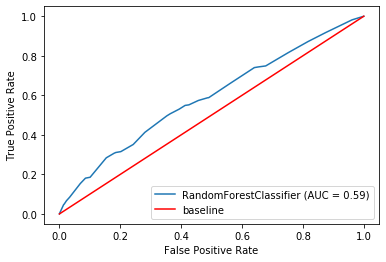

<Figure size 432x288 with 0 Axes>

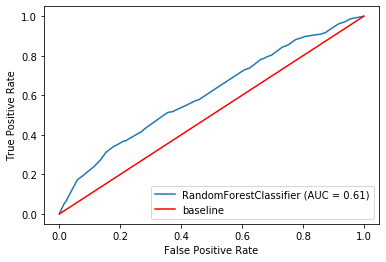

In [43]:
#ADASYN
RandomForest(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[0.12 0.   0.02 0.02 0.   0.02 0.82]

 ADABOOST
CONFUSION MATRIX
[[179235 105930]
 [122035 165896]]
              precision    recall  f1-score   support

           0       0.59      0.63      0.61    285165
           1       0.61      0.58      0.59    287931

    accuracy                           0.60    573096
   macro avg       0.60      0.60      0.60    573096
weighted avg       0.60      0.60      0.60    573096


ROC CURVE: 0.60


<Figure size 432x288 with 0 Axes>

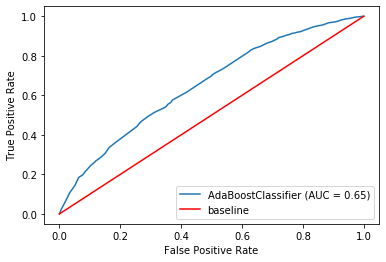

In [44]:
adaboost(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[0.08865529 0.08615492 0.15911503 0.0834528  0.16871352 0.06596925
 0.3479392 ]

 XGBoost
CONFUSION MATRIX
[[163093 122072]
 [ 99707 188224]]
              precision    recall  f1-score   support

           0       0.62      0.57      0.60    285165
           1       0.61      0.65      0.63    287931

    accuracy                           0.61    573096
   macro avg       0.61      0.61      0.61    573096
weighted avg       0.61      0.61      0.61    573096


ROC CURVE: 0.61


<Figure size 432x288 with 0 Axes>

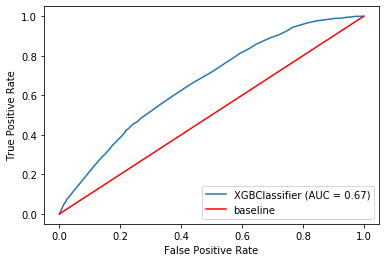

In [45]:
xgboost(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156798 131133]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.50    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[140603 144562]
 [104311 183620]]
              precision    recall  f1-score   support

           0       0.57      0.49      0.53    285165
           1       0.56      0.64      0.60    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.56    573096
weighted avg       0.57      0.57      0.56    573096


ROC CURVE: 0.57


<Figure size 432x288 with 0 Axes>

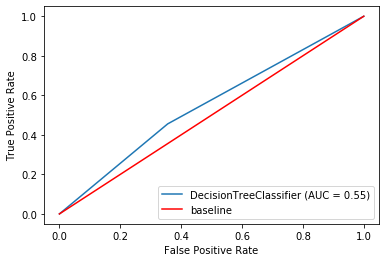

<Figure size 432x288 with 0 Axes>

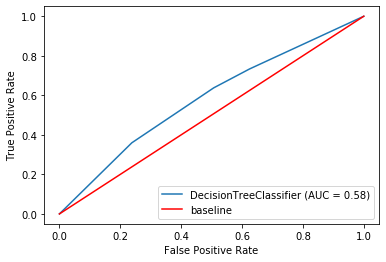

In [46]:
DT(X_train_ad,y_train_ad,X_test_ad,y_test_ad)


 K-Neighbours (n_neighbors:3)
CONFUSION MATRIX
[[171516 113649]
 [100307 187624]]
              precision    recall  f1-score   support

           0       0.63      0.60      0.62    285165
           1       0.62      0.65      0.64    287931

    accuracy                           0.63    573096
   macro avg       0.63      0.63      0.63    573096
weighted avg       0.63      0.63      0.63    573096


ROC CURVE: 0.63

 K-Neighbours (n_neighbors:25)
CONFUSION MATRIX
[[167982 117183]
 [ 84240 203691]]
              precision    recall  f1-score   support

           0       0.67      0.59      0.63    285165
           1       0.63      0.71      0.67    287931

    accuracy                           0.65    573096
   macro avg       0.65      0.65      0.65    573096
weighted avg       0.65      0.65      0.65    573096


ROC CURVE: 0.65

 K-Neighbours (n_neighbors:50)
CONFUSION MATRIX
[[157181 127984]
 [ 69127 218804]]
              precision    recall  f1-score   support

      

<Figure size 432x288 with 0 Axes>

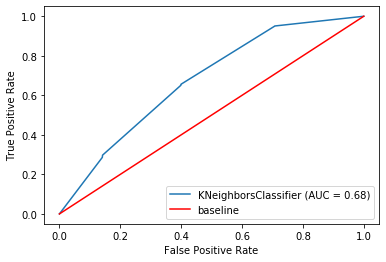

<Figure size 432x288 with 0 Axes>

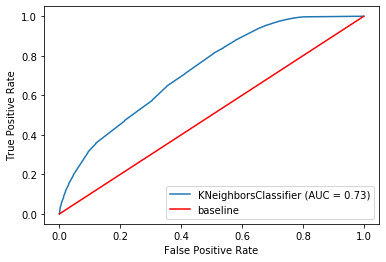

<Figure size 432x288 with 0 Axes>

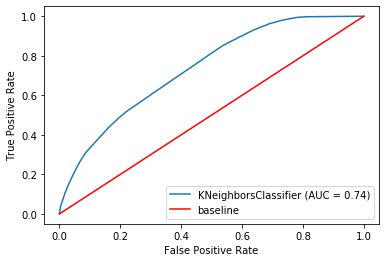

In [47]:
KNN(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[LibSVM]
 SVCL (C=0.01)
CONFUSION MATRIX
[[ 86088 199077]
 [ 84791 203140]]
              precision    recall  f1-score   support

           0       0.50      0.30      0.38    285165
           1       0.51      0.71      0.59    287931

    accuracy                           0.50    573096
   macro avg       0.50      0.50      0.48    573096
weighted avg       0.50      0.50      0.48    573096


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.10)
CONFUSION MATRIX
[[ 86088 199077]
 [ 84791 203140]]
              precision    recall  f1-score   support

           0       0.50      0.30      0.38    285165
           1       0.51      0.71      0.59    287931

    accuracy                           0.50    573096
   macro avg       0.50      0.50      0.48    573096
weighted avg       0.50      0.50      0.48    573096


ROC CURVE: 0.50
[LibSVM]
 SVCL (C=0.50)
CONFUSION MATRIX
[[ 86088 199077]
 [ 84791 203140]]
              precision    recall  f1-score   support

           0       0.50      

<Figure size 432x288 with 0 Axes>

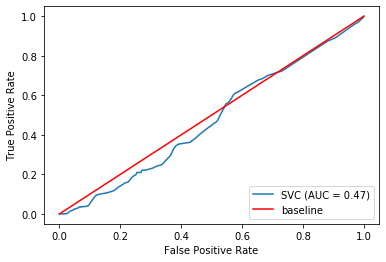

<Figure size 432x288 with 0 Axes>

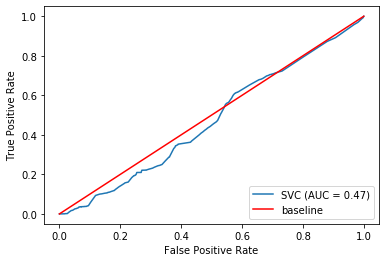

<Figure size 432x288 with 0 Axes>

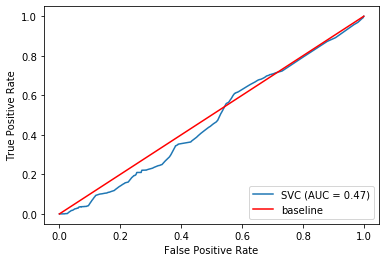

<Figure size 432x288 with 0 Axes>

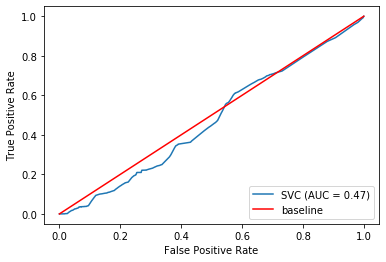

In [48]:
SVCL(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

dep: 1
[0.18 0.   0.22 0.11 0.13 0.07 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[145272 139893]
 [118574 169357]]
              precision    recall  f1-score   support

           0       0.55      0.51      0.53    285165
           1       0.55      0.59      0.57    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096


ROC CURVE: 0.55
dep: 2
[0.19572729 0.01946375 0.13810714 0.05654713 0.09196022 0.02491108
 0.4732834 ]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[166643 118522]
 [130210 157721]]
              precision    recall  f1-score   support

           0       0.56      0.58      0.57    285165
           1       0.57      0.55      0.56    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.57    573096
weighted avg       0.57      0.57      0.57    573096


ROC CURVE: 0.57


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

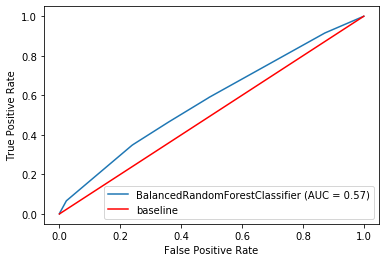

<Figure size 432x288 with 0 Axes>

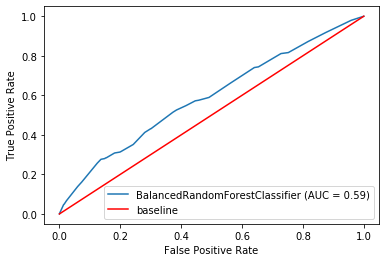

In [49]:
BalancedRF(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  3.3min remaining:  3.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.7s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   17.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  9.3min remaining:  9.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don


 Easy Ensemble Classifier (n_estimators: 10)
CONFUSION MATRIX
[[184955 100210]
 [127721 160210]]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62    285165
           1       0.62      0.56      0.58    287931

    accuracy                           0.60    573096
   macro avg       0.60      0.60      0.60    573096
weighted avg       0.60      0.60      0.60    573096


ROC CURVE: 0.60

 Easy Ensemble Classifier (n_estimators: 25)
CONFUSION MATRIX
[[184619 100546]
 [127261 160670]]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62    285165
           1       0.62      0.56      0.59    287931

    accuracy                           0.60    573096
   macro avg       0.60      0.60      0.60    573096
weighted avg       0.60      0.60      0.60    573096


ROC CURVE: 0.60

 Easy Ensemble Classifier (n_estimators: 50)
CONFUSION MATRIX
[[184606 100559]
 [127232 160699]]
              prec

<Figure size 432x288 with 0 Axes>

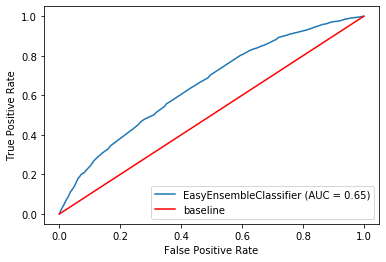

<Figure size 432x288 with 0 Axes>

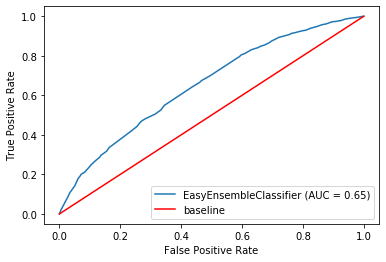

<Figure size 432x288 with 0 Axes>

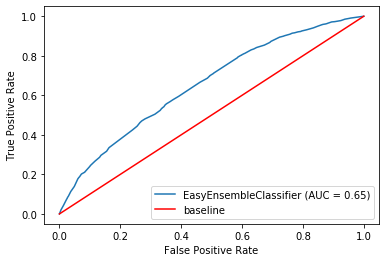

In [50]:
EasyEnsamble(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 10)
CONFUSION MATRIX
[[183725 101440]
 [156798 131133]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.50    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 25)
CONFUSION MATRIX
[[183725 101440]
 [156798 131133]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.50    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096


ROC CURVE: 0.55
[0. 0. 0. 0. 0. 0. 1.]

 RUS Boost Classifier (n_estimators: 50)
CONFUSION MAT

<Figure size 432x288 with 0 Axes>

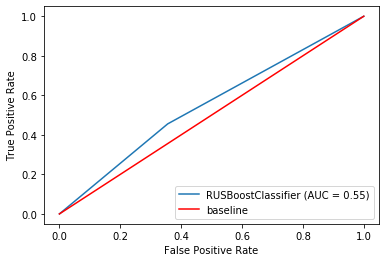

<Figure size 432x288 with 0 Axes>

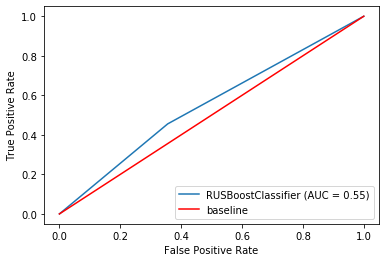

<Figure size 432x288 with 0 Axes>

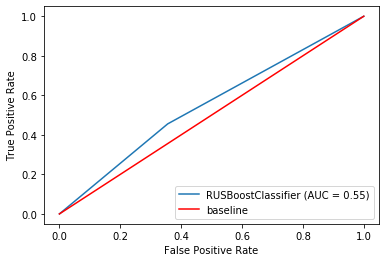

In [51]:
RUSBoost(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

In [52]:
CB(X_train_ad,y_train_ad,X_test_ad,y_test_ad)

0:	learn: 0.6929780	total: 288ms	remaining: 4m 47s
1:	learn: 0.6928229	total: 567ms	remaining: 4m 43s
2:	learn: 0.6926594	total: 895ms	remaining: 4m 57s
3:	learn: 0.6924983	total: 1.21s	remaining: 5m 2s
4:	learn: 0.6923413	total: 1.55s	remaining: 5m 7s
5:	learn: 0.6921862	total: 1.88s	remaining: 5m 11s
6:	learn: 0.6920354	total: 2.21s	remaining: 5m 13s
7:	learn: 0.6918870	total: 2.54s	remaining: 5m 15s
8:	learn: 0.6917409	total: 2.87s	remaining: 5m 15s
9:	learn: 0.6915981	total: 3.17s	remaining: 5m 14s
10:	learn: 0.6914584	total: 3.51s	remaining: 5m 15s
11:	learn: 0.6913208	total: 3.84s	remaining: 5m 16s
12:	learn: 0.6911872	total: 4.14s	remaining: 5m 14s
13:	learn: 0.6910532	total: 4.47s	remaining: 5m 14s
14:	learn: 0.6909170	total: 4.83s	remaining: 5m 16s
15:	learn: 0.6907888	total: 5.14s	remaining: 5m 16s
16:	learn: 0.6906629	total: 5.44s	remaining: 5m 14s
17:	learn: 0.6905391	total: 5.75s	remaining: 5m 13s
18:	learn: 0.6904177	total: 6.1s	remaining: 5m 15s
19:	learn: 0.6902983	tota